# Zacros kMC for O-Pt(111)

In [1]:
import numpy as np
from pathlib import Path
import subprocess, os
import scm.pyzacros as pz
import zacros_functions as zf

In [2]:
# Path to Zacros executables
zacros_path = Path("/home/akandra/zacros/zacros_4.0/build_intel")
zacros3_path = Path("/home/akandra/zacros/zacros_3.03/build_std")

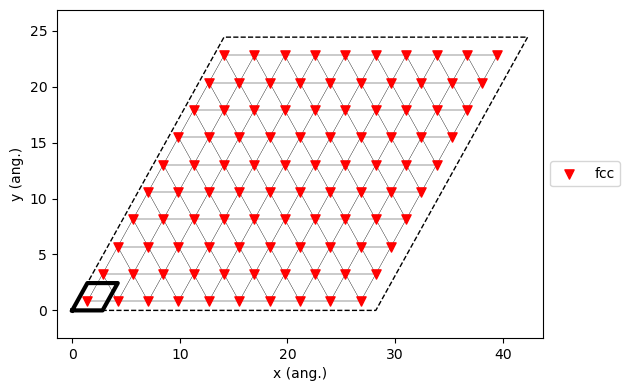

In [ ]:
# Setting up a system and running Zacros simulations

# lattice setup
lattice_constant = 2.821135  # in Angstroms 
# lattice vectors for Pt(111)
unit_cell = lattice_constant*np.array([ 
                                [1.0,         0.0],
                                [0.5, np.sqrt(3)/2] ])
lat_size = "40x40"

# Zacros run directory
run_dir = "zacros_run"

# Adsorbates
ads_name = 'O*'

# Cluster definition
def clusters(n):

  # 2-body clusters up to 9nn for Pt(111) from Florian's DFT calculations
  cluster_list_all =  [0,     1,     2,      3,     4,     5,     6,     7,     8,    9]
  eng_list_all =    [0.0, 0.123, 0.029, -0.010, 0.023, 0.023, 0.015, 0.016, 0.030, 0.014]

  cluster_list = cluster_list_all[:n+1]
  eng_list = eng_list_all[:n+1]
  cl_dir = f'upto{n}nn'

  return cluster_list, eng_list, cl_dir

# Get lattice size from lat_size string
Nx_lat, Ny_lat = [int(y) for y in lat_size.split('x')]

# Visualize lattice using pyzacros
lattice = pz.Lattice(cell_vectors=unit_cell,
                        repeat_cell=[10,10],
                         site_types=["fcc"],
                   site_coordinates=[(0.333333333333333,0.333333333333333)],
                   neighboring_structure=[ [(0,0), pz.Lattice.NORTH],
                                           [(0,0), pz.Lattice.EAST],
                                           [(0,0), pz.Lattice.SOUTHEAST] ] )
lattice.plot()

In [ ]:
# Loop over different coverages
temperature = 70  # in Kelvin
cluster_list, eng_list, cl_dir = clusters(9)

for coverage in [0.02, 0.05,0.1]:

    wdir = Path(f"{run_dir}_{int(round(1000*coverage)):04d}_{cl_dir}_{temperature:04d}")
    try:
        wdir.mkdir(exist_ok=False)
    except FileExistsError:
        print(f"Directory {wdir} already exists. Skipping...")
        continue

    # Number of adsorbates
    N_ads = int(coverage * Nx_lat * Ny_lat)

    # Setup Zacros input 
    header = "Pt(111)"+lat_size
    zf.make_lattice_input(wdir, 1, 1, unit_cell, Nx_lat, Ny_lat, header=header)
    zf.make_mechanism_input(wdir, header=header)
    zf.make_energetics_input(wdir, cluster_list, eng_list)
    zf.make_state_input(wdir, [(ads_name,N_ads)], header=header)
    zf.make_simulation_input(wdir, temperature=temperature, max_steps=50000, snapshots='on event 500', wall_time=3600,   header=header)

    # Change to Zacros run directory
    original_dir = os.getcwd()
    os.chdir(wdir)

    try:
        # Run zacros.x
        result = subprocess.run([str(zacros_path / "zacros.x")], 
                            check=True,
                            capture_output=True,
                            text=True)
        print(result.stdout)
        
    except subprocess.CalledProcessError as e:
        print("Error running zacros.x:")
        print(e.stderr)
        
    finally:
        # Change back to original directory
        os.chdir(original_dir)
        


Directory zacros_run_0020_upto9nn_0070 already exists. Skipping...
Directory zacros_run_0050_upto9nn_0070 already exists. Skipping...


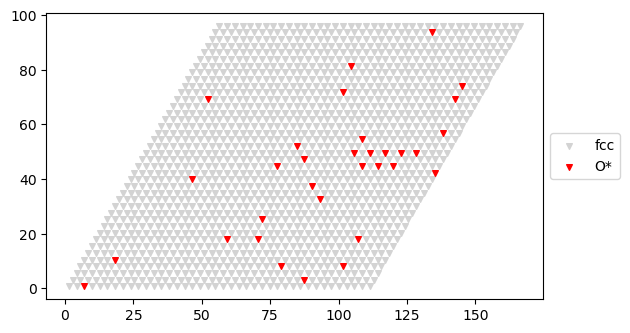

In [11]:
zf.lattice_plot(Path.cwd() /"zacros_run_0020_upto3nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

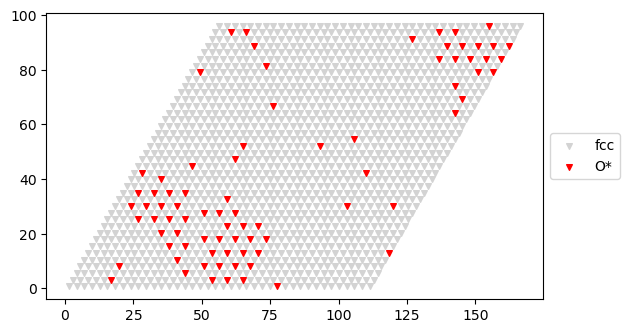

In [12]:

zf.lattice_plot(Path.cwd() /"zacros_run_0050_upto3nn_0070/lattice_input.dat", show_axes=True, pause=0,close=False)

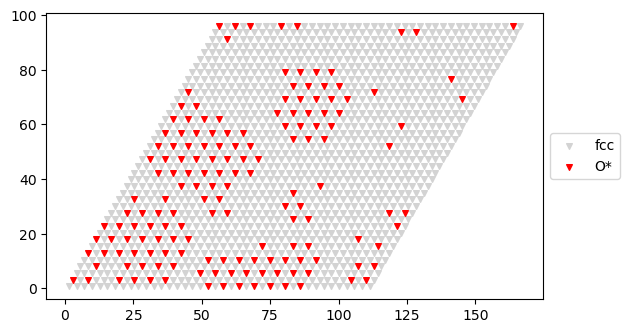

In [7]:
zf.lattice_plot(Path.cwd() /"zacros_run_0100_upto3nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

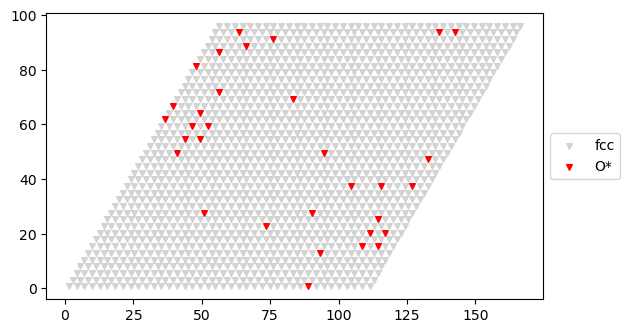

In [15]:
zf.lattice_plot(Path.cwd() /"zacros_run_0020_upto5nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

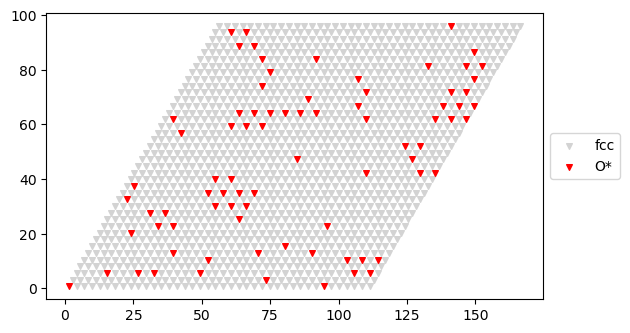

In [17]:
zf.lattice_plot(Path.cwd() /"zacros_run_0050_upto5nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

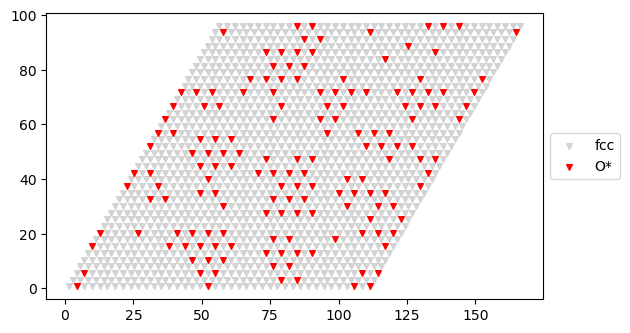

In [9]:
zf.lattice_plot(Path.cwd() /"zacros_run_0100_upto5nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

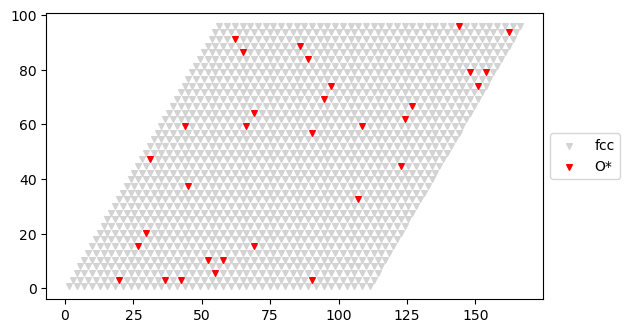

In [5]:
zf.lattice_plot(Path.cwd() /"zacros_run_0020_upto9nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

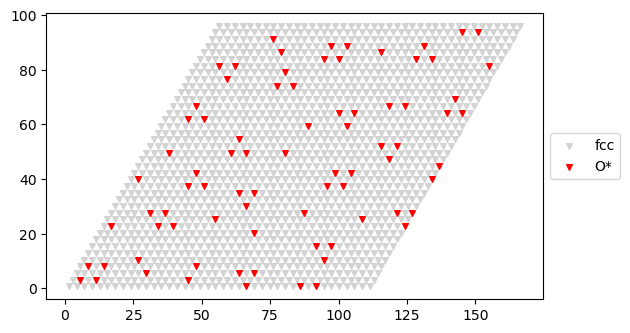

In [4]:
zf.lattice_plot(Path.cwd() /"zacros_run_0050_upto9nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

In [ ]:
zf.lattice_plot(Path.cwd() /"zacros_run_0100_upto9nn_0070/lattice_input.dat", show_axes=True, pause=0.,close=False)

In [ ]:
n_clusters = []
cluster_counts = []
lat_sizes = [f"{i}x{i}" for i in range(3, 15)]
for lat_size in lat_sizes:

    with open(run_dir / lat_size / 'energlist_output.txt', 'r') as file:
        lines = file.readlines()

    cl_names = lines[0].split()[1:]
    for i, line in enumerate(lines):
        if 'energetics_list_entry' in line: break
        
    n_clusters.append(int(lines[i+1].split()[0]))
    cluster_list = [int(line.split()[0]) for line in lines[i+2: i+2+n_clusters[-1]]]

    cluster_counts.append([cluster_list.count(i) for i in range(1, 11)])


# Extract lattice sizes as numbers (e.g., '3x3' -> 3)
x_vals = [int(size.split('x')[0]) for size in lat_sizes]

for i in range(10):

    plt.figure()
    plt.xlabel('Lattice Size (N)')
    plt.ylabel('# of Clusters / # of adsorbates')
    plt.title(f'# of {cl_names[i]} clusters')
    plt.grid(True)

    y_vals = [cluster_counts[l][i]/nsites**2 for l, nsites in enumerate(x_vals)]
    plt.plot(x_vals, y_vals,'o-')




TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
96/16

6.0